# 3-a: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



<b>Students:
<pre>
VU Anh Thu            <font color=blue>21322736</font>
LE Thi Minh Nguyet    <font color=blue>21401438</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [3]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10, 10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

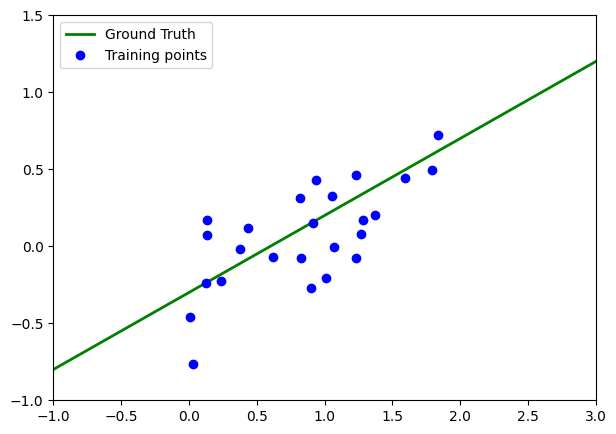

In [4]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [5]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [6]:
# TODO: Define basis function

def phi_linear(x):
    """ Linear Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) linear features of x
    """
    # TODO
    return np.array([1, x])

**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

**Answer:**
*   The closed form of the posterior distribution is $\mathcal{N}(\mu, Σ)$ where
\begin{equation}
\Sigma^{-1} = \alpha I_2 + \beta \Phi^T\Phi = \begin{pmatrix}
\alpha + \beta n & \beta \sum_{i=1}^n x_i \\
\beta \sum_{i=1}^n x_i  & \alpha + \beta \sum_{i=1}^n x_i^2
\end{pmatrix}
\end{equation}
and \begin{equation}
\mu = \beta \Sigma \Phi^T Y \quad \text{where} \quad Y = \begin{pmatrix}
     y_1 \\
    ... \\
     y_n
  \end{pmatrix}
\end{equation}

*   It can be observed that as the number of training samples, $n$, increases, the value of $w$ that maximizes the posterior density is closer to the true value of $w$. Moreover, as $n$ increases, the posterior distribution becomes more peaked, meaning that the posterior certainty increases.



<ipython-input-7-007f943924fb>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )


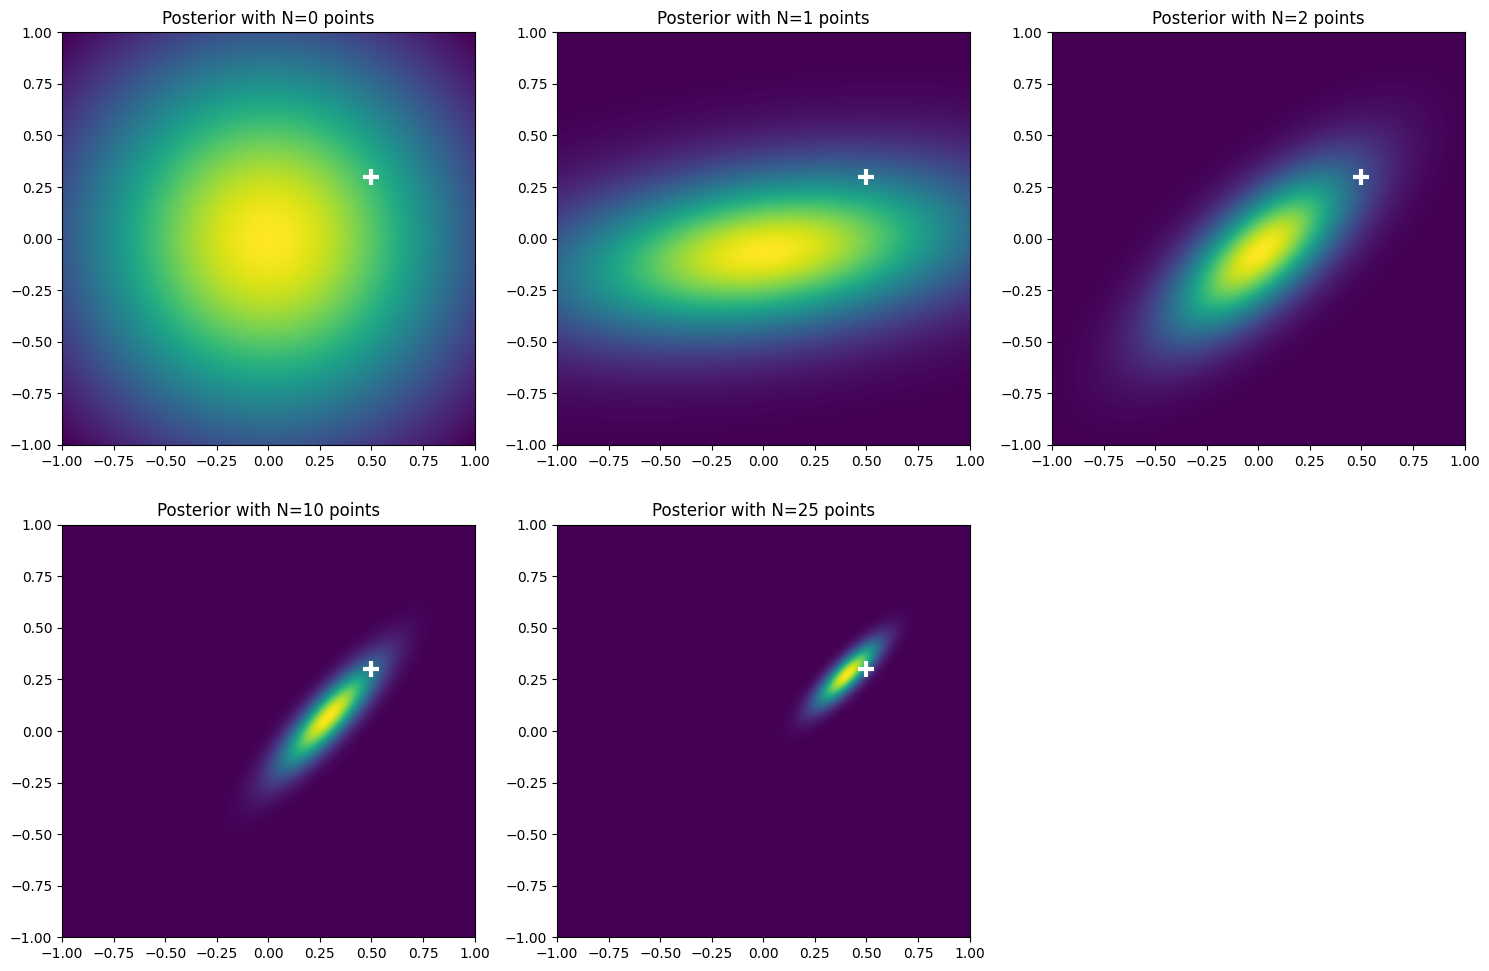

In [7]:
# TODO: Code and visualize posterior sampling by completing code below

plt.figure(figsize=(15,10))
alpha = dataset_linear['ALPHA']
beta = dataset_linear['BETA']

for count, n in enumerate([0, 1, 2, 10, len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))

    # TODO: code mu_n and sigma_N
    if n == 0:
      mu_N = np.zeros((2,1))
      sigma_N = np.eye(2)/alpha
    else:
      phi = np.vstack([phi_linear(x) for x in cur_data])
      sigma_N = np.linalg.inv(alpha*np.eye(2) + beta*np.dot(phi.T, phi))
      mu_N = beta*sigma_N.dot(phi.T).dot(cur_lbl)
    # END TODO


    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z

    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

**Answer:**
*   The closed form of the predictive distribution is $$
\mathcal{N}\left(\mu^T \Phi(x^*), \frac{1}{\beta} + \Phi(x^*)^T \Sigma \Phi(x^*)\right)
$$
where $\mu$ and $\Sigma$ are the same as in the closed form of the posterior distribution and
$$
\Phi(x^*) =  \begin{pmatrix}
    1 \\
    x^*
  \end{pmatrix}
$$


In [8]:
# TODO: Code closed form solution according to the following requirements defined below

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """

    # TODO

    phi = np.vstack([func(x_train) for x_train in X_train])
    d = phi.shape[1]
    sigma_N = np.linalg.inv(alpha*np.eye(d) + beta*np.dot(phi.T, phi))
    mu_N = beta*sigma_N.dot(phi.T).dot(y_train)
    def f_model(x) :
      mean = np.dot(mu_N, func(x))
      std = np.sqrt(1/beta + np.dot(np.dot(func(x), sigma_N), func(x)))
      return mean, std
    # END TODO

    return f_model

In [9]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

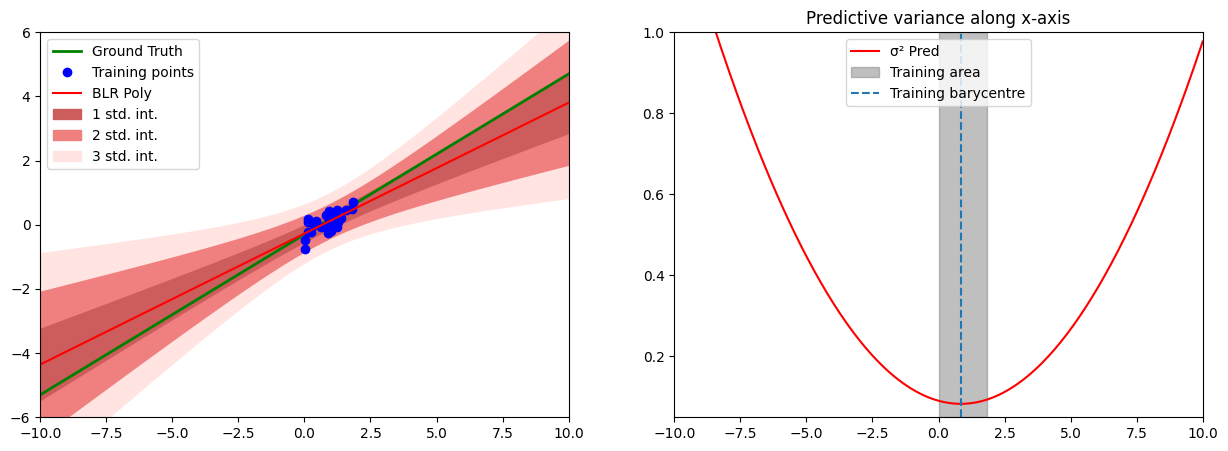

In [10]:
# TODO : predict on test dataset and visualize results

# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1

means = []
stds = []
for x in dataset_linear['X_test']:
    mean, std = f_pred(x)
    means.append(mean)
    stds.append(std)
means = np.array(means)
stds = np.array(stds)

plot_results(dataset_linear['X_train'], dataset_linear['y_train'], dataset_linear['X_test'], dataset_linear['y_test'], means, stds,
             xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1.)

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

**Answer:**

*   It can be observed that the predictive variance increases as the test data moves farther away from the training distribution. This can be explained by the fact that as the test data moves farther away from the training distribution, the epistemic uncertainty increases. Meanwhile, the aleatoric uncertainty remains irreducible, leading to an overall increase in the uncertainty of the prediction. Moreover, we can see that the predictive variance is minimized at the barycenter of the training dataset, i.e. at the empirical mean of X_train.

*   When $\alpha=0$ and $\beta=1$,
\begin{equation}
\Sigma^{-1} = \begin{pmatrix}
n & \sum_{i=1}^n x_i \\
\sum_{i=1}^n x_i  & \sum_{i=1}^n x_i^2
\end{pmatrix}
\end{equation}
where $(x_i)_{1 \leq i \leq n}$ are the training data.
Thus,
\begin{equation}
\Sigma = \frac{1}{n \sum_{i=1}^n x_i^2 - (\sum_{i=1}^n x_i)^2}\begin{pmatrix}
\sum_{i=1}^n x_i^2 & -\sum_{i=1}^n x_i \\
-\sum_{i=1}^n x_i  & n
\end{pmatrix}
= \frac{1}{n\sigma_n^2} \begin{pmatrix}
\overline{x^2_n} & -\overline{x_n} \\
-\overline{x_n}  & 1
\end{pmatrix}
\end{equation}
where $\sigma_n^2$ and $\overline{x_n}$ are the empirical variance and mean of $(x_i)_{1 \leq i \leq n}$, respectively, and $\overline{x^2_n}$ is the empirical mean of $(x_i^2)_{1 \leq i \leq n}$. Therefore, we obtain
\begin{equation}
\Phi(x^*)^T \Sigma \Phi(x^*) = \frac{1}{n\sigma_n^2} \left[ \overline{x^2_n} - (\overline{x_n})^2 + (\overline{x_n} - x^*)^2 \right]
\end{equation}
Since the predictive variance is minimized if and only if $\Phi(x^*)^T \Sigma \Phi(x^*)$ is minimized, it follows that the predictive variance is minimized if and only if $(\overline{x_n} - x^*)^2$ is minimized. Therefore, the predictive variance is minimized if and only if $x^* = \overline{x_n}$. Moreover, as the test data $x^*$ moves farther away from the empirical mean $\overline{x_n}$, the predictive variance will increase.

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

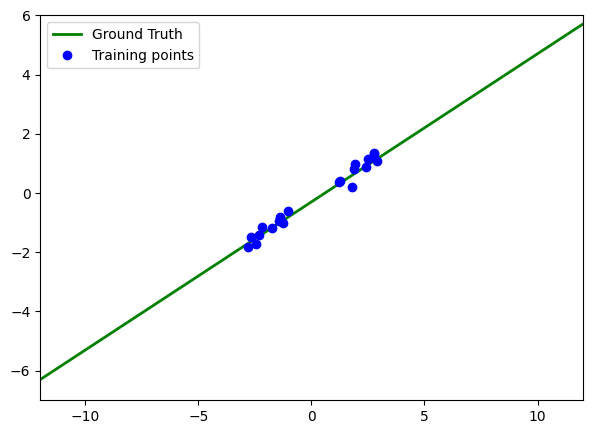

In [11]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12, 12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

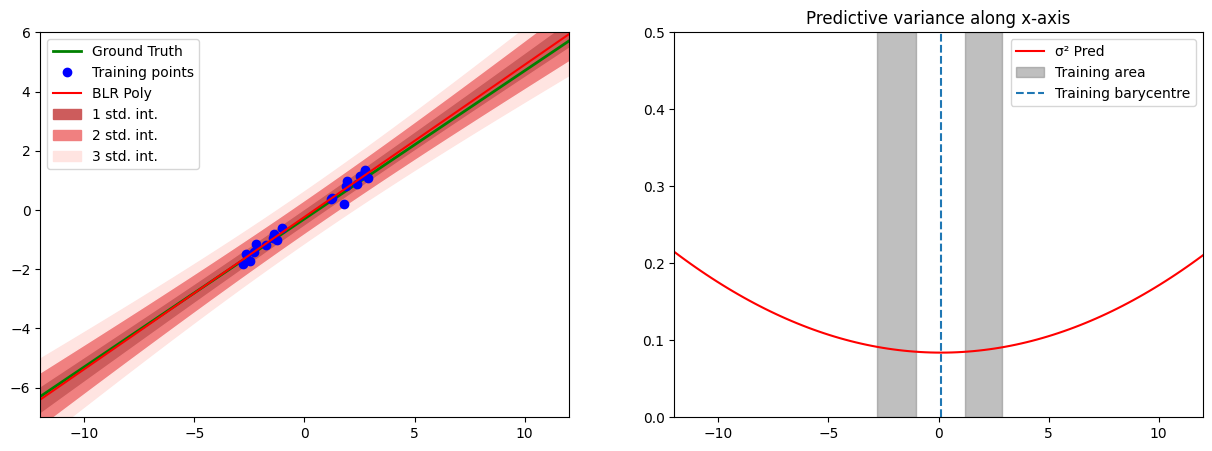

In [12]:
# TODO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5
f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                     dataset_hole['ALPHA'], dataset_hole['BETA'])

means = []
stds = []
for x in dataset_hole['X_test']:
    mean, std = f_pred(x)
    means.append(mean)
    stds.append(std)
means = np.array(means)
stds = np.array(stds)

plot_results(dataset_hole['X_train'], dataset_hole['y_train'], dataset_hole['X_test'], dataset_hole['y_test'], means, stds,
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0., stdmax=0.5)

**Answer:** It can be observed that the same behavior of the predictive variance occurs when applying Bayesian Linear Regession to the new training dataset as it does with the previous dataset. As we can see, the predictive variance also increases as the test data moves farther away from the training distribution. However, we can see that the predictive variance is minimized at the empirical mean of the training dataset, which, indeed, is not a datapoint in the training dataset. This seems counterintuitive because the model is most confident at a point it has not seen, suggesting that we may need to choose a different prior distribution and likelihood for this training dataset.

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

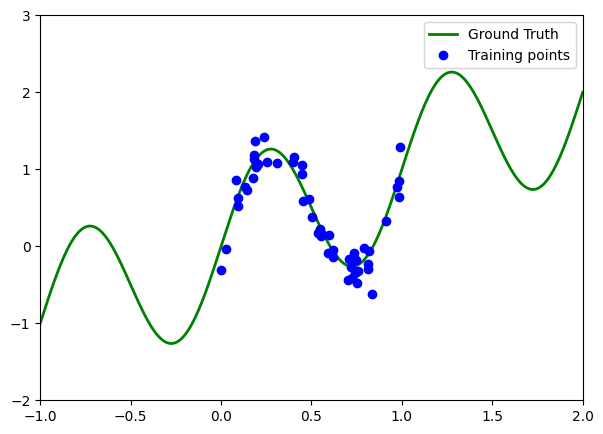

In [13]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [14]:
# Define basis function
def phi_polynomial(x):
    """ Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    D = 10
    # TODO
    return np.array([x**i for i in range(D)])

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

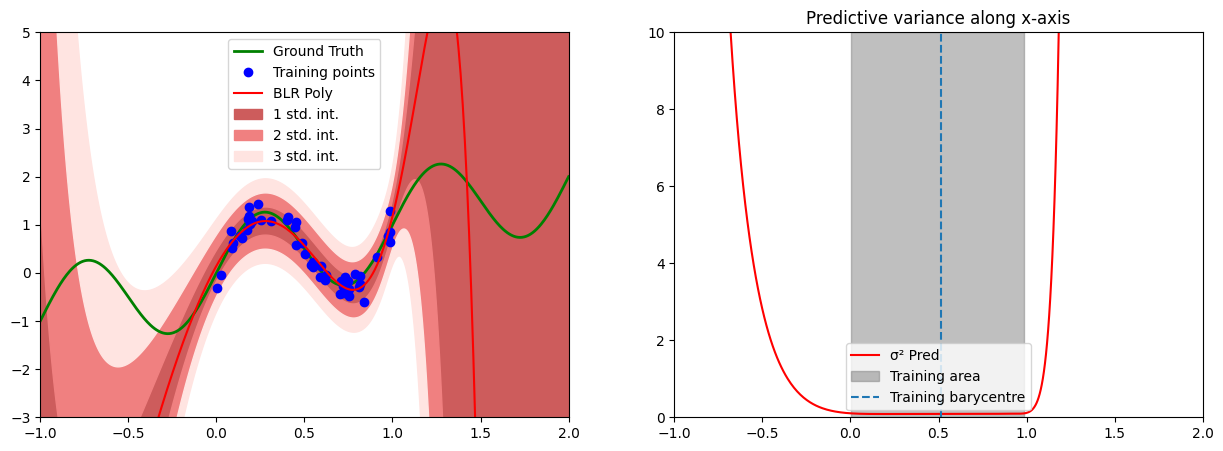

In [15]:
# TODO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

f_pred = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])
means = []
stds = []
for x in dataset_sinus['X_test']:
    mean, std = f_pred(x)
    means.append(mean)
    stds.append(std)
means = np.array(means)
stds = np.array(stds)

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'], means, stds,
             xmin=-1., xmax=2., ymin=-3., ymax=5., stdmin=0., stdmax=10.)

**Answer:** A polynomial of degree $9$ fits the training data well with a very high certainty (the predictive variance in the training area is nearly zero), however, its performance on unseen data is poor, especially in regions far from the training points. Similar to the behaviors observed in linear datasets, the predictive variance increases significantly as we move further from the training data.

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [16]:
# TODO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x) :
    """ Gaussian Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/M
    return np.exp(-(x - np.arange(MU_MIN, MU_MAX, s)) ** 2 / (2 * s * s))

**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

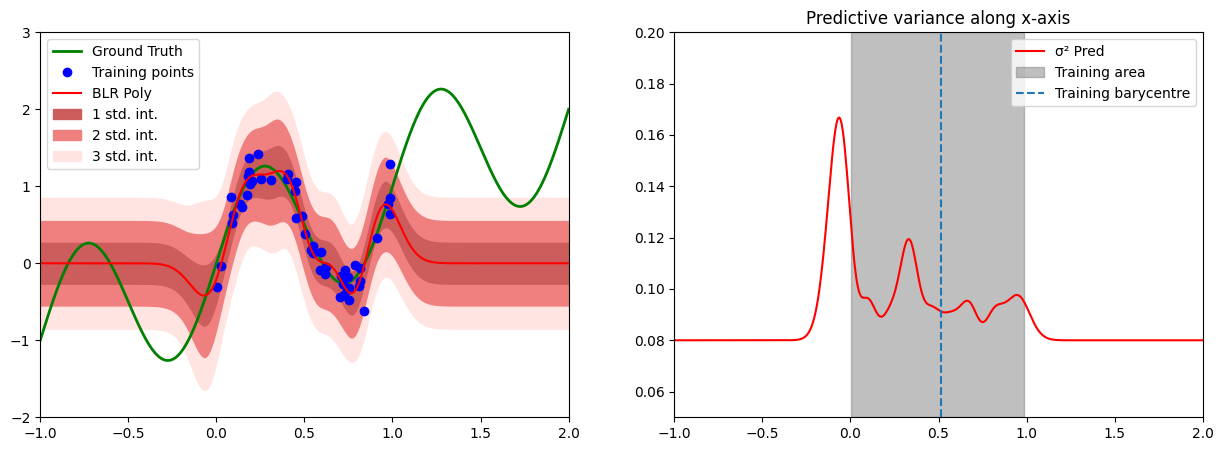

In [17]:
# TO DO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

f_pred = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

means = []
stds = []
for x in dataset_sinus['X_test']:
    mean, std = f_pred(x)
    means.append(mean)
    stds.append(std)
means = np.array(means)
stds = np.array(stds)

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'], means, stds,
             xmin=-1., xmax=2., ymin=-2., ymax=3., stdmin=0.05, stdmax=0.2)

**Answer:** Unlike the previous cases for linear and polynomial basis functions, here the predicted variance is higher in the training region and converges to a fixed value, nearly zero, in regions far from the training distribution. Despite this extremely low uncertainty, the model's predictions are significantly incorrect. Moreover, the predicted variance in training regions also exhibits noticeable fluctuations. These fluctuations arise because Gaussian basis functions are localized around $\mu_j$ and thus $\Phi(x^*)$ can be sensitive to the arrangement of $\mu_j$.

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

**Answer:**
In order to explain this phenomenon, let us recall the predictive variance
\begin{equation}
\frac{1}{\beta} + \Phi(x^*)^T \Sigma \Phi(x^*)
\end{equation}
where
\begin{equation}
\Phi(x^*) = \begin{pmatrix}
    \phi_0(x^*) \\ \phi_1(x^*) \\... \\ \phi_M(x^*) \\
  \end{pmatrix}
\quad \text{with} \quad \phi_j(x^*) = \exp \Big (-\frac{(x^* -\mu_j)^2}{2s^2} \Big ) \quad \text{for} \quad 1 \leq j \leq M
\end{equation}
where $(\mu_j)_{1 \leq j \leq M}$ are equally spaced points in the training domain and $x^*$ is the test data.

Thus, if the test data $x^*$ lies in regions far from the training distribution, $\exp \Big (-\frac{(x^* -\mu_j)^2}{2s^2} \Big )$ converges to $0$ for all $1 \leq j \leq M$, leading to $\Phi(x^*)^T \Sigma \Phi(x^*)$ also converging to $0$. As a consequence, the predictive variance converges to $\frac{1}{\beta}$, which equals $0.08$, as shown in the figure above.

**In conclusion**, after this lab, we can see that Bayesian Learning is a powerful tool for partially mitigating the limitation of Deep Neural Networks, such as overconfidence. However, the performance of Bayesian models depends significantly on the choices of some critical components, including the prior distribution, likelihood, and basis functions, as demonstrated in the lab.